# Downloading and Extracting data:

Downloading two datasets. Images and annotations from the the Oxford-IIIT Pet Dataset.
Extract datasets using the tar command

In [4]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz


--2023-12-16 20:56:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-12-16 20:56:38--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-12-16 20:56:39--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

#  Preparing File Paths for Image and Annoations:

Create list of file paths for JPEG images and PNG trimap annoations. A trimap s used to define the foreground, background and transitional areas of an image.

We sort the file paths alphabetically from their named directories.

In [6]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")]
)

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")]
)

# Displaying an Image

We display a specific image from the dataset using Matplotlib

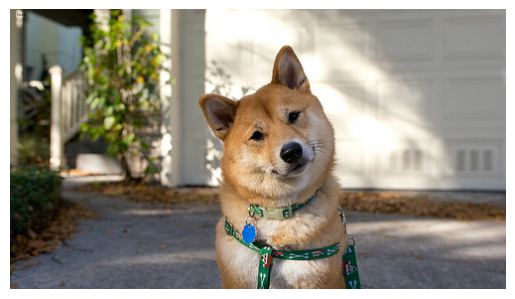

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[-10]))

# Displaying a Target Annotation:

Creating a function display_target which takes an array representing an image, normalizes it, and then displays it using matplotlib.

We load a specific grayscale target image and display it using this function.

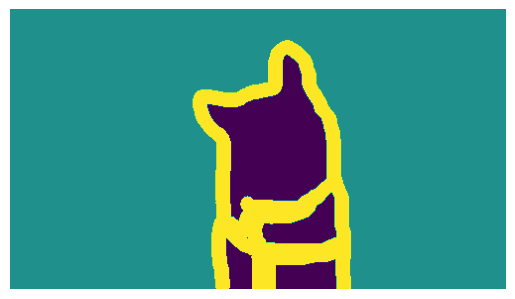

In [38]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") -1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[-10], color_mode="grayscale"))
display_target(img)

# Data Preparation for Model Training

We initialize the image size, shuffle image and target paths, and define functions to process these paths into NumPy arrays suitable for model training.
We split the dataset into training and validation sets.

In [17]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size=img_size, color_mode="grayscale")
  )
  img = img.astype("uint8") -1
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])


num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# Creating a Convolutional Neural Network Model

Creating our CNN model using Tensorflow Keras.
Includes Convolutional layers, transpose convolutional layers, and a final softmax layer for classification.

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation="softmax",
                          padding="same")(x)

  model = keras.Model(inputs, outputs)
  return model



In [24]:
model = get_model(img_size=img_size, num_classes=3)


In [25]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_22 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_23 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_24 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 256)       2951

# Model Compilation and Training

Intialise CNN model, compile it with RMSprop optimizer and sparse categorical crossentropy loss (due to pixel by pixel classification, many potential classes).

Included a callback for saving the best model during training (as normally model eventually gets worse with more epochs as it overfits). We then train the model on the prepared datasets.

In [26]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))




Epoch 1/50
100/100 [==============================] - 122s 933ms/step - loss: 0.9487 - val_loss: 0.9089
Epoch 2/50
100/100 [==============================] - 62s 621ms/step - loss: 0.8822 - val_loss: 0.8430
Epoch 3/50
100/100 [==============================] - 63s 634ms/step - loss: 0.8294 - val_loss: 0.8218
Epoch 4/50
100/100 [==============================] - 61s 607ms/step - loss: 0.7912 - val_loss: 0.8066
Epoch 5/50
100/100 [==============================] - 63s 632ms/step - loss: 0.7780 - val_loss: 0.7841
Epoch 6/50
100/100 [==============================] - 64s 638ms/step - loss: 0.7631 - val_loss: 0.8254
Epoch 7/50
100/100 [==============================] - 61s 611ms/step - loss: 0.7489 - val_loss: 0.7326
Epoch 8/50
100/100 [==============================] - 63s 628ms/step - loss: 0.7410 - val_loss: 0.7625
Epoch 9/50
100/100 [==============================] - 62s 619ms/step - loss: 0.7053 - val_loss: 0.6655
Epoch 10/50
100/100 [==============================] - 61s 612ms/step - 

# Plotting Training and Validation Loss

Plot training and validation loss over epochs

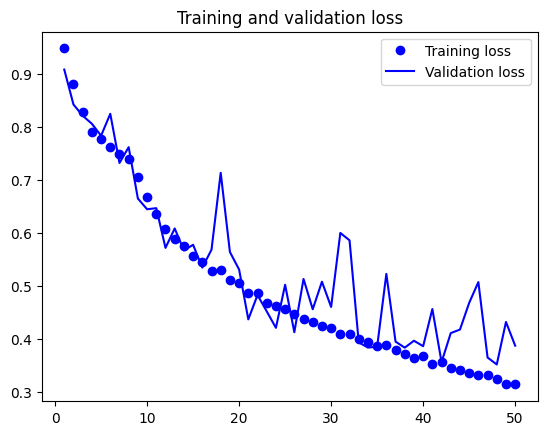

In [27]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

# Model Evaluation with Test Image and Displaying Predicted Mask

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = -15
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *=127
  plt.axis("off")
  plt.imshow(mask)

display_mask(mask)